In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/DLassigData


archive.zip


In [ ]:
!unzip /content/drive/MyDrive/DLassigData/archive.zip -d /content/

Archive:  /content/drive/MyDrive/DLassigData/archive.zip
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: /content/Skin cancer ISIC The International Skin

In [ ]:
# Step 2: Import necessary modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import tensorflow as tf
import os

In [ ]:
import os

base_dir = Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration')  # Adjust this path if necessary
train_dir = base_dir/'Train'
test_dir = base_dir/'Test'

In [ ]:
import random

batch_size = 64
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
import tensorflow as tf

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


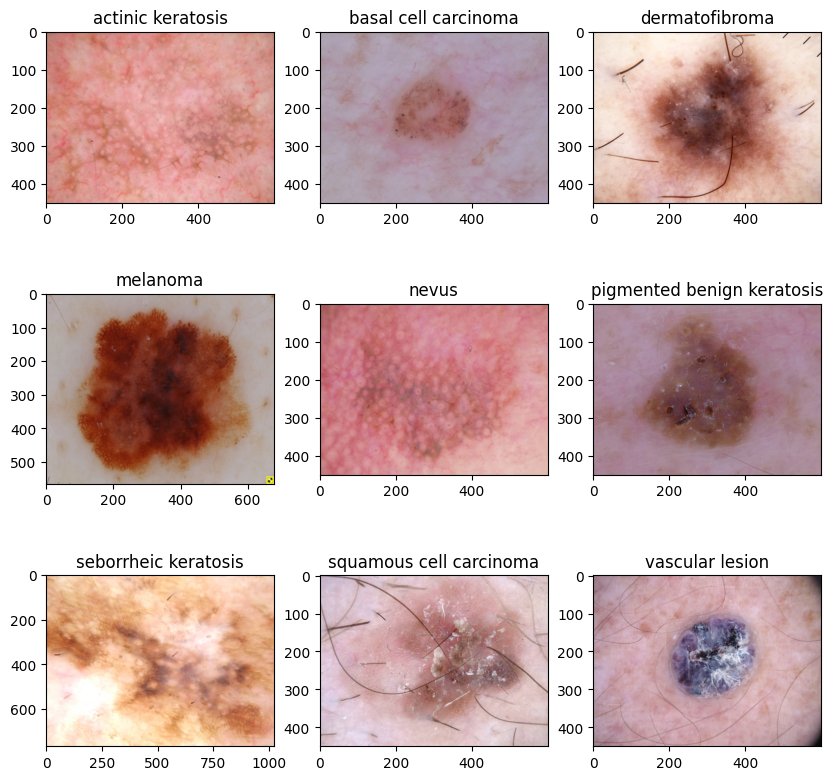

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from glob import glob

num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [ ]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(64, 180, 180, 3)
(64,)


Own network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu', batch_norm=True, dropout_rate=0.0):
    shortcut = x

    # First layer of the residual block
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)

    # Second layer of the residual block
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(0.001))(x)
    if batch_norm:
        x = BatchNormalization()(x)

    # Add dropout if specified
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    # Add a 1x1 convolution to the shortcut connection if the number of filters is different
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(0.001))(shortcut)

    # Add the shortcut connection
    x = Add()([x, shortcut])
    x = tf.keras.layers.Activation(activation)(x)

    return x

def build_advanced_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Residual Block 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 2
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 3
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs, outputs)
    return model

In [ ]:
# Define input shape and number of classes
input_shape = (224, 224, 3)  # Adjust this according to your dataset
num_classes = 9  # Adjust this according to your dataset

In [ ]:
# Build the model
model = build_advanced_cnn(input_shape, num_classes)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use a portion of training data for validation
)

# Training generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    train_dir,  # Adjust this path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 224, 224, 64)         256       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)         0         ['batch_normalization_7[0]

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, mode='min')

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/30
57/57 [==============================] - 57s 996ms/step - loss: 2.8745 - accuracy: 0.4596 - val_loss: 3.0323 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - 57s 1s/step - loss: 2.8344 - accuracy: 0.4440 - val_loss: 5.0778 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 3/30
57/57 [==============================] - 66s 1s/step - loss: 2.6897 - accuracy: 0.4479 - val_loss: 2.7642 - val_accuracy: 0.4144 - lr: 0.0010
Epoch 4/30
57/57 [==============================] - 57s 999ms/step - loss: 2.5584 - accuracy: 0.4774 - val_loss: 2.5908 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 5/30
57/57 [==============================] - 56s 985ms/step - loss: 2.4675 - accuracy: 0.4713 - val_loss: 2.8493 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 6/30
57/57 [==============================] - 57s 993ms/step - loss: 2.4946 - accuracy: 0.4435 - val_loss: 4.1776 - val_accuracy: 0.1644 - lr: 0.0010
Epoch 7/30
57/57 [==============================] - 57s 997ms/step - l

Alexnet

In [ ]:
import tensorflow.keras.datasets as datasets
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.optimizers
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
num_classes=9
def AlexNet():
    model1 = Sequential([
        Rescaling(1.0/255, input_shape=(img_height, img_width, 3))
    ])

    model1.add(Conv2D(96, 11,padding="same",activation='relu'))
    model1.add(MaxPool2D(pool_size=(3,3),strides=2,padding='valid'))

    model1.add(Conv2D(256, 5,padding="same",activation='relu'))
    model1.add(MaxPool2D(pool_size=(3,3),strides=2,padding='valid'))

    model1.add(Conv2D(384, 3,padding="same",activation='relu'))
    model1.add(Conv2D(384, 3,padding="same",activation='relu'))
    model1.add(Conv2D(256, 3,padding="same",activation='relu'))
    model1.add(MaxPool2D(pool_size=(3,3),strides=2,padding='valid'))


    model1.add(Flatten())
    model1.add(Dense(4096,activation="relu"))
    model1.add(Dense(4096,activation="relu"))
    model1.add(Dense(units=num_classes, activation= 'softmax'))

    return model1

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Rescaling
alexmodel=AlexNet()

In [ ]:
opt = Adam(learning_rate=0.001)
alexmodel.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
callbacks=[TensorBoard(log_dir='./logs')]

In [ ]:
alexmodel.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=30,
  callbacks=callbacks,
  batch_size=16

)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 [==============================] - 69s 1s/step - loss: 9.1914 - accuracy: 0.2070 - val_loss: 2.0901 - val_accuracy: 0.2058
Epoch 2/30
28/28 [==============================] - 24s 758ms/step - loss: 2.0353 - accuracy: 0.2098 - val_loss: 2.0391 - val_accuracy: 0.2058
Epoch 3/30
28/28 [==============================] - 25s 800ms/step - loss: 2.0200 - accuracy: 0.1981 - val_loss: 2.0348 - val_accuracy: 0.2058
Epoch 4/30
28/28 [==============================] - 25s 777ms/step - loss: 2.0194 - accuracy: 0.1959 - val_loss: 2.0365 - val_accuracy: 0.2058
Epoch 5/30
28/28 [==============================] - 25s 790ms/step - loss: 2.0199 - accuracy: 0.1981 - val_loss: 2.0262 - val_accuracy: 0.2058
Epoch 6/30
28/28 [==============================] - 23s 724ms/step - loss: 2.0379 - accuracy: 0.1964 - val_loss: 2.0539 - val_accuracy: 0.1924
Epoch 7/30
28/28 [==============================] - 24s 699ms/step - loss: 2.0288 - accuracy: 0.1992 - val_loss: 2.0293 - val_accuracy: 0.2058
Epoch 8/30
28

Resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,UpSampling2D,Input
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)

val_generator=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)

test_generator=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)

In [ ]:
inputs=Input(shape=(180,180,3))

In [ ]:
resized_inputs=UpSampling2D(size=(7,7))(inputs)
print(resized_inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 1260, 1260, 3), dtype=tf.float32, name=None), name='up_sampling2d/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d'")


In [ ]:
resnet_model=ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resized_inputs
)

for layer in resnet_model.layers:
    layer.trainable=False

NUM_LAYERS_TO_UNFREEZE = 40
for layer in resnet_model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable=True

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
x=GlobalAveragePooling2D()(resnet_model.output)
x=Dense(1024,activation="relu",dtype=tf.float16)(x)
x=BatchNormalization()(x)
x=Dropout(0.3)(x)
x=Dense(512,activation="relu",dtype=tf.float16)(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(256,activation="relu",dtype=tf.float16)(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)

In [ ]:
classification_output=Dense(9,activation="softmax",name="classification")(x)

In [ ]:
ResNet_model=Model(inputs=inputs,outputs=classification_output,name="ResNet")

In [ ]:
optimizer = tf.keras.optimizers.Adam()
ResNet_model.compile(optimizer= optimizer,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
num_layers = len(ResNet_model.layers)
print('Numer of layers in the model: ',num_layers)

Numer of layers in the model:  187


In [ ]:
batch_size=4
epochs=20

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=1,min_lr=0.00001)
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)

In [ ]:
history=ResNet_model.fit(train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  batch_size=4)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


ResourceExhaustedError: Graph execution error:

Detected at node ResNet/conv1_conv/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-80-f6be6495bcce>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[64,64,630,630] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node ResNet/conv1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_447170]

Googlenet

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Activation
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np

In [ ]:
def inceptionnet(x,filters):
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    #(5x5) layer
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])

In [ ]:
def helperfunction(x,name=None):
    layer=AveragePooling2D(pool_size=(3,3),strides=3,padding="valid")(x)
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    layer=Flatten()(layer)
    layer=Dense(units=255,activation="relu")(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=9,activation="softmax",name=name)(layer)
    return layer

In [ ]:
def googlenet():
    #taking layer input
    inputlayer=Input(shape=(180,180,3))
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    layer=BatchNormalization()(layer)
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    #layer_6
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=9,activation="softmax",name="final_layer_2")(layer)
    model2=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    return model2

In [ ]:
googlemodel=googlenet()

In [ ]:
optimizer = tf.keras.optimizers.Adam()
googlemodel.compile(optimizer= optimizer,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

In [ ]:
googlemodel.fit(train_dataset,epochs=10,shuffle=True)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 [==============================] - 55s 684ms/step - loss: 22.8118 - final_layer_2_loss: 18.4777 - final_layer_0_loss: 2.2405 - final_layer_1_loss: 2.0936 - final_layer_2_accuracy: 0.2277 - final_layer_0_accuracy: 0.2455 - final_layer_1_accuracy: 0.2288
Epoch 2/10
28/28 [==============================] - 82s 3s/step - loss: 5.0623 - final_layer_2_loss: 1.7301 - final_layer_0_loss: 1.6271 - final_layer_1_loss: 1.7051 - final_layer_2_accuracy: 0.3828 - final_layer_0_accuracy: 0.4202 - final_layer_1_accuracy: 0.3984
Epoch 3/10
28/28 [==============================] - 24s 696ms/step - loss: 4.6416 - final_layer_2_loss: 1.6288 - final_layer_0_loss: 1.4633 - final_layer_1_loss: 1.5495 - final_layer_2_accuracy: 0.4191 - final_layer_0_accuracy: 0.4810 - final_layer_1_accuracy: 0.4604
Epoch 4/10
28/28 [==============================] - 22s 687ms/step - loss: 4.2327 - final_layer_2_loss: 1.4570 - final_layer_0_loss: 1.3671 - final_layer_1_loss: 1.4086 - final_layer_2_accuracy: 0.4609 - fina

Densenet

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import cifar10
import numpy as np

In [ ]:
num_classes = 9
num_dense_blocks = 2
use_max_pool = False
growth_rate = 8
depth = 20
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)
num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

In [ ]:
# Reduce input size
input_shape = (180,180, 3)  # More aggressive reduction in input size
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

In [ ]:
# Build DenseNet model
for i in range(num_dense_blocks):
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate, kernel_size=1, padding='same', kernel_initializer='he_normal')(y)
        y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate, kernel_size=3, padding='same', kernel_initializer='he_normal')(y)
        y = Dropout(0.2)(y)
        x = concatenate([x, y])
    if i == num_dense_blocks - 1:
        continue
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block, kernel_size=1, padding='same', kernel_initializer='he_normal')(y)
    y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)

In [ ]:
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes, kernel_initializer='he_normal', activation='softmax')(y)

In [ ]:
dense_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = Adam()
dense_model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
# Define a very small batch size
batch_size = 4  # Further reduce batch size

In [ ]:

# Assuming `train_dataset` and `val_dataset` are your datasets
history = dense_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size=batch_size
)

Epoch 1/5
28/28 [==============================] - 64s 1s/step - loss: 1.8445 - accuracy: 0.3901 - val_loss: 15.6259 - val_accuracy: 0.1051
Epoch 2/5
28/28 [==============================] - 36s 1s/step - loss: 1.4105 - accuracy: 0.4967 - val_loss: 7.5307 - val_accuracy: 0.2170
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 1.2863 - accuracy: 0.5458 - val_loss: 4.0817 - val_accuracy: 0.2058
Epoch 4/5
28/28 [==============================] - 36s 1s/step - loss: 1.1749 - accuracy: 0.5898 - val_loss: 3.7735 - val_accuracy: 0.2058
Epoch 5/5
28/28 [==============================] - 33s 995ms/step - loss: 1.0588 - accuracy: 0.6272 - val_loss: 4.3351 - val_accuracy: 0.1812
